In [12]:
import os
import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt
import seaborn as sns

# === 基本設定 ===
base = "../ML4G_Project_1_Data"
marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
cells = ["X1", "X2", "X3"]
target_chroms = [f"chr{i}" for i in range(1, 23)]

summary = []

def extract_signal(bw, chrom_list, step_scale=500000):
    """從 pyBigWig 讀取多個 chr 的 sampled signal"""
    chroms = bw.chroms()
    vals = []
    for chrom in chrom_list:
        if chrom not in chroms:
            continue
        length = chroms[chrom]
        step = max(length // step_scale, 1000)
        v = np.array(bw.values(chrom, 0, length, numpy=True)[::step])
        v = v[~np.isnan(v)]
        vals.extend(v)
    return np.array(vals)

for mark in marks:
    for cell in cells:
        path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bw")
        if not os.path.exists(path_bw):
            path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bigwig")
        if not os.path.exists(path_bw):
            print(f"⚠️ Missing: {mark} ({cell})")
            continue

        print(f"\n📂 Reading {mark} ({cell}) ...")
        bw = pyBigWig.open(path_bw)

        # chr1
        vals_chr1 = extract_signal(bw, ["chr1"])
        # chr2–22
        vals_train = extract_signal(bw, [f"chr{i}" for i in range(2, 23)])
        # all chr1–22
        vals_all = np.concatenate([vals_chr1, vals_train])
        bw.close()

        # === 儲存統計結果 ===
        for region, vals in zip(["chr1", "chr2-22", "chr1-22"], [vals_chr1, vals_train, vals_all]):
            if len(vals) == 0:
                continue
            summary.append({
                "mark": mark,
                "cell": cell,
                "region": region,
                "mean": float(np.mean(vals)),
                "std": float(np.std(vals)),
                "min": float(np.min(vals)),
                "max": float(np.max(vals)),
                "median": float(np.median(vals)),
            })

# === 匯出 summary ===
summary_df = pd.DataFrame(summary)
summary_df.to_csv("bigwig_signal_summary_chr1_vs_chr2-22.csv", index=False)
print("\n✅ Saved → bigwig_signal_summary_chr1_vs_chr2-22.csv")



📂 Reading DNase (X1) ...

📂 Reading DNase (X2) ...

📂 Reading DNase (X3) ...

📂 Reading H3K27ac (X1) ...

📂 Reading H3K27ac (X2) ...

📂 Reading H3K27ac (X3) ...

📂 Reading H3K4me3 (X1) ...

📂 Reading H3K4me3 (X2) ...

📂 Reading H3K4me3 (X3) ...

📂 Reading H3K27me3 (X1) ...

📂 Reading H3K27me3 (X2) ...

📂 Reading H3K27me3 (X3) ...

📂 Reading H3K36me3 (X1) ...

📂 Reading H3K36me3 (X2) ...

📂 Reading H3K36me3 (X3) ...

📂 Reading H3K4me1 (X1) ...

📂 Reading H3K4me1 (X2) ...

📂 Reading H3K4me1 (X3) ...

📂 Reading H3K9me3 (X1) ...

📂 Reading H3K9me3 (X2) ...

📂 Reading H3K9me3 (X3) ...

✅ Saved → bigwig_signal_summary_chr1_vs_chr2-22.csv


In [11]:
import os
import numpy as np
import pandas as pd
import pyBigWig

# === 基本設定 ===
base = "../ML4G_Project_1_Data"
marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
cells = ["X1", "X2", "X3"]
target_chroms = [f"chr{i}" for i in range(1, 23)]

summary = []

for mark in marks:
    for cell in cells:
        # === 找檔案 ===
        path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bw")
        if not os.path.exists(path_bw):
            path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bigwig")
        if not os.path.exists(path_bw):
            print(f"⚠️ Missing: {mark} ({cell})")
            continue

        print(f"\n📂 Processing {mark} ({cell}) ...")
        bw = pyBigWig.open(path_bw)
        chroms = bw.chroms()

        # 初始化統計量
        total_bp_chr1 = total_bp_train = 0
        sum_chr1 = sum_train = 0
        sq_sum_chr1 = sq_sum_train = 0
        min_chr1 = min_train = np.inf
        max_chr1 = max_train = -np.inf

        # === 逐 chr 統計 ===
        for chrom in target_chroms:
            if chrom not in chroms:
                continue
            vals = np.array(bw.values(chrom, 0, chroms[chrom], numpy=True))
            vals = vals[~np.isnan(vals)]
            n = len(vals)
            if n == 0:
                continue

            mean_chr = np.mean(vals)
            std_chr = np.std(vals)

            # 更新 min/max
            min_chr = np.min(vals)
            max_chr = np.max(vals)

            # 累積統計（分開 chr1 vs chr2–22）
            if chrom == "chr1":
                total_bp_chr1 += n
                sum_chr1 += n * mean_chr
                sq_sum_chr1 += n * (std_chr**2 + mean_chr**2)
                min_chr1 = min(min_chr1, min_chr)
                max_chr1 = max(max_chr1, max_chr)
            else:
                total_bp_train += n
                sum_train += n * mean_chr
                sq_sum_train += n * (std_chr**2 + mean_chr**2)
                min_train = min(min_train, min_chr)
                max_train = max(max_train, max_chr)

        bw.close()

        # === chr1 統計 ===
        if total_bp_chr1 > 0:
            mean_chr1 = sum_chr1 / total_bp_chr1
            var_chr1 = sq_sum_chr1 / total_bp_chr1 - mean_chr1**2
            std_chr1 = np.sqrt(var_chr1)
        else:
            mean_chr1 = std_chr1 = np.nan

        # === chr2–22 統計 ===
        if total_bp_train > 0:
            mean_train = sum_train / total_bp_train
            var_train = sq_sum_train / total_bp_train - mean_train**2
            std_train = np.sqrt(var_train)
        else:
            mean_train = std_train = np.nan

        # === 全域 chr1–22 統計 ===
        total_bp_all = total_bp_chr1 + total_bp_train
        mean_all = (sum_chr1 + sum_train) / total_bp_all
        var_all = (sq_sum_chr1 + sq_sum_train) / total_bp_all - mean_all**2
        std_all = np.sqrt(var_all)
        min_all = min(min_chr1, min_train)
        max_all = max(max_chr1, max_train)

        # === 儲存結果 ===
        summary.extend([
            {"mark": mark, "cell": cell, "region": "chr1", "mean": mean_chr1, "std": std_chr1,
             "min": min_chr1, "max": max_chr1, "count": total_bp_chr1},
            {"mark": mark, "cell": cell, "region": "chr2-22", "mean": mean_train, "std": std_train,
             "min": min_train, "max": max_train, "count": total_bp_train},
            {"mark": mark, "cell": cell, "region": "chr1-22", "mean": mean_all, "std": std_all,
             "min": min_all, "max": max_all, "count": total_bp_all},
        ])

        print(f"✅ Done {mark}-{cell}: mean_all={mean_all:.4f}, std_all={std_all:.4f}")

# === 輸出結果 ===
summary_df = pd.DataFrame(summary)
summary_df.to_csv("bigwig_signal_summary_weighted_chr1_vs_chr2-22.csv", index=False)
print("\n💾 Saved → bigwig_signal_summary_weighted_chr1_vs_chr2-22.csv")



📂 Processing DNase (X1) ...
✅ Done DNase-X1: mean_all=0.0591, std_all=0.1919

📂 Processing DNase (X2) ...
✅ Done DNase-X2: mean_all=0.0406, std_all=7.5742

📂 Processing DNase (X3) ...
✅ Done DNase-X3: mean_all=0.0512, std_all=4.4270

📂 Processing H3K27ac (X1) ...
✅ Done H3K27ac-X1: mean_all=0.5643, std_all=3.6970

📂 Processing H3K27ac (X2) ...
✅ Done H3K27ac-X2: mean_all=0.8620, std_all=4.5804

📂 Processing H3K27ac (X3) ...
✅ Done H3K27ac-X3: mean_all=0.7923, std_all=5.4479

📂 Processing H3K4me3 (X1) ...
✅ Done H3K4me3-X1: mean_all=0.4574, std_all=3.8905

📂 Processing H3K4me3 (X2) ...
✅ Done H3K4me3-X2: mean_all=0.3699, std_all=3.5539

📂 Processing H3K4me3 (X3) ...
✅ Done H3K4me3-X3: mean_all=0.5178, std_all=5.1500

📂 Processing H3K27me3 (X1) ...
✅ Done H3K27me3-X1: mean_all=0.9886, std_all=2.5569

📂 Processing H3K27me3 (X2) ...
✅ Done H3K27me3-X2: mean_all=0.2052, std_all=1.5275

📂 Processing H3K27me3 (X3) ...
✅ Done H3K27me3-X3: mean_all=0.3860, std_all=1.0821

📂 Processing H3K36me3

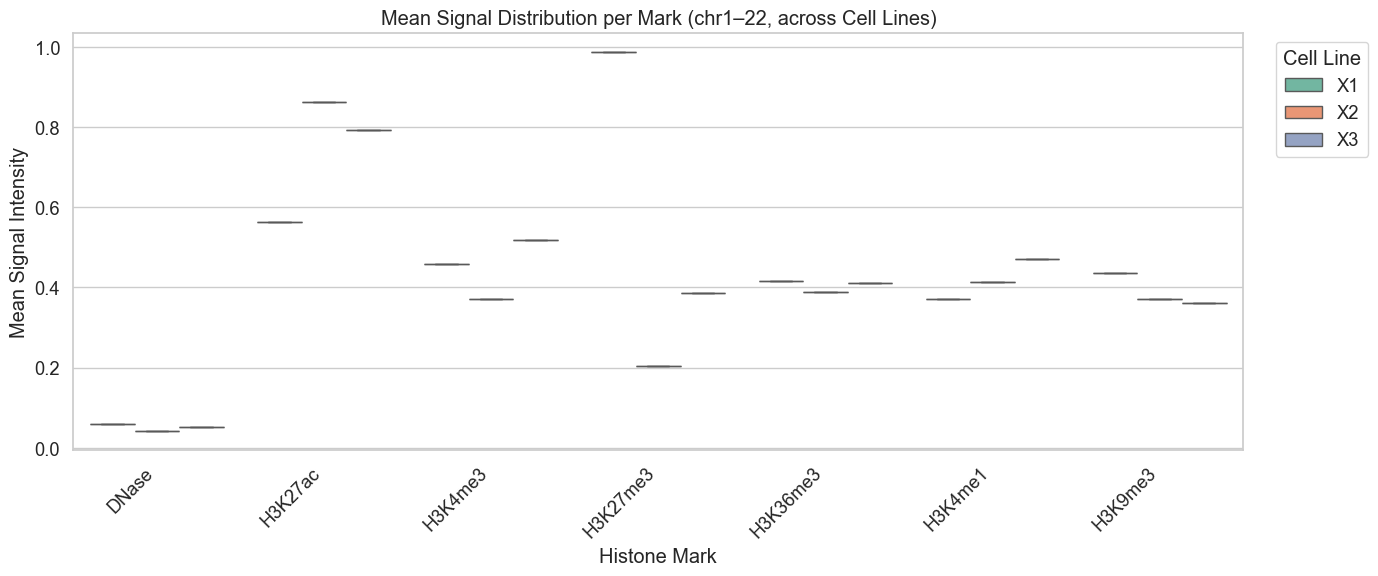

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 篩選只保留 chr1–22 ===
df_all = summary_df[summary_df["region"] == "chr1-22"].copy()

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df_all,
    x="mark", 
    y="mean",
    hue="cell",         # 比較不同 cell line
    palette="Set2",
    showfliers=False
)

plt.title("Mean Signal Distribution per Mark (chr1–22, across Cell Lines)")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Histone Mark")
plt.ylabel("Mean Signal Intensity")
plt.legend(title="Cell Line", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()



📂 Processing DNase (X1) ...

📂 Processing DNase (X2) ...

📂 Processing DNase (X3) ...

📂 Processing H3K27ac (X1) ...

📂 Processing H3K27ac (X2) ...

📂 Processing H3K27ac (X3) ...

📂 Processing H3K4me3 (X1) ...

📂 Processing H3K4me3 (X2) ...

📂 Processing H3K4me3 (X3) ...

📂 Processing H3K27me3 (X1) ...

📂 Processing H3K27me3 (X2) ...

📂 Processing H3K27me3 (X3) ...

📂 Processing H3K36me3 (X1) ...

📂 Processing H3K36me3 (X2) ...

📂 Processing H3K36me3 (X3) ...

📂 Processing H3K4me1 (X1) ...

📂 Processing H3K4me1 (X2) ...

📂 Processing H3K4me1 (X3) ...

📂 Processing H3K9me3 (X1) ...

📂 Processing H3K9me3 (X2) ...

📂 Processing H3K9me3 (X3) ...


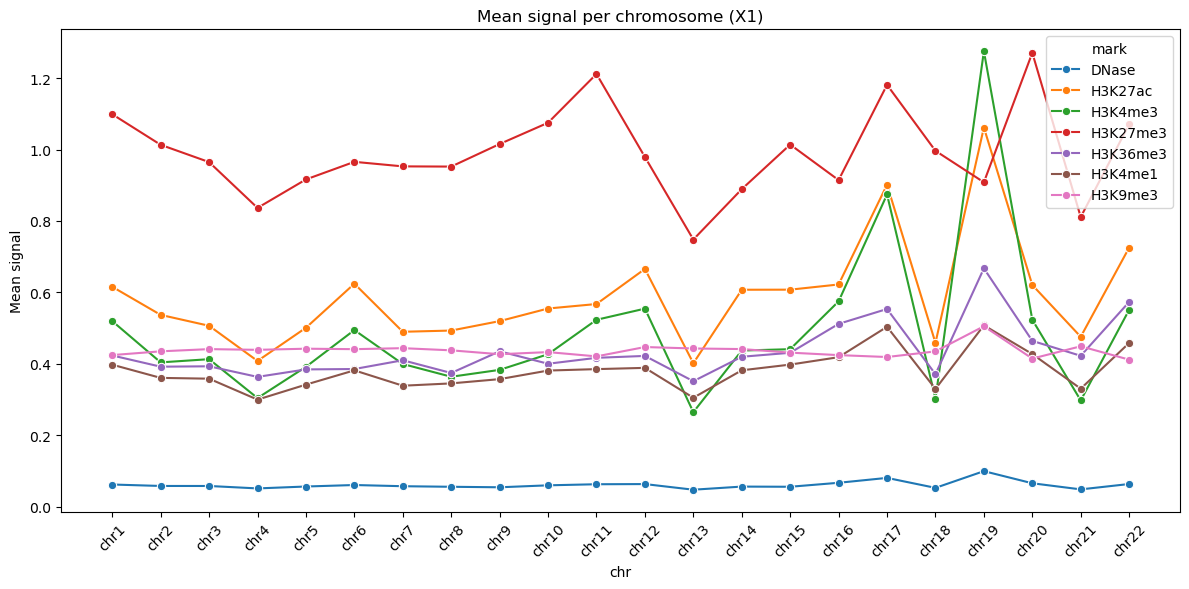

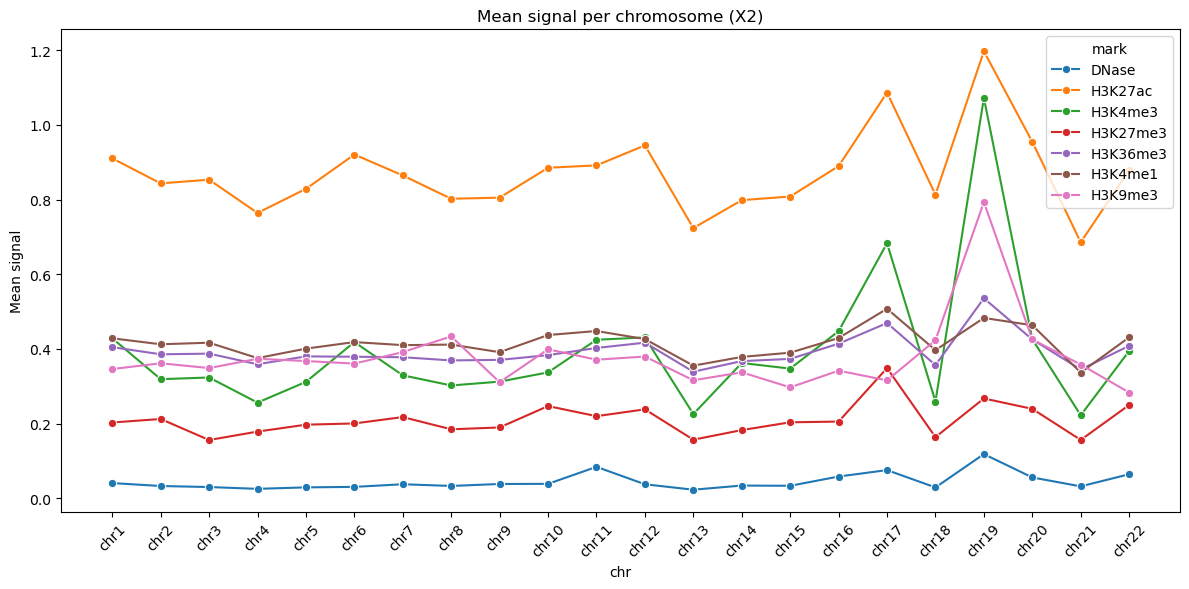

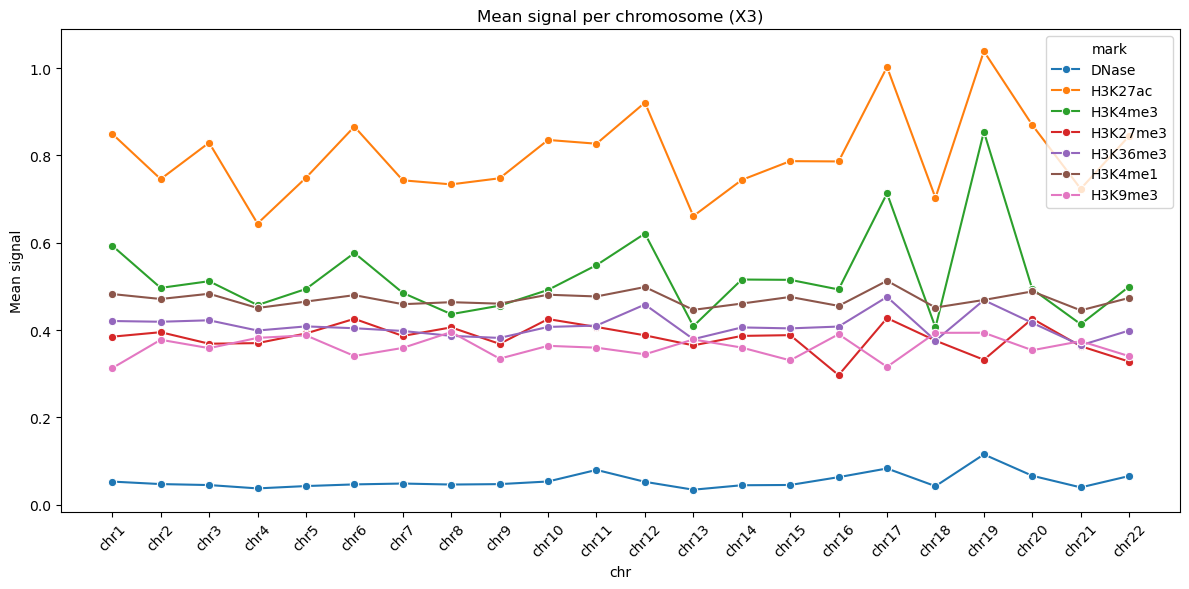

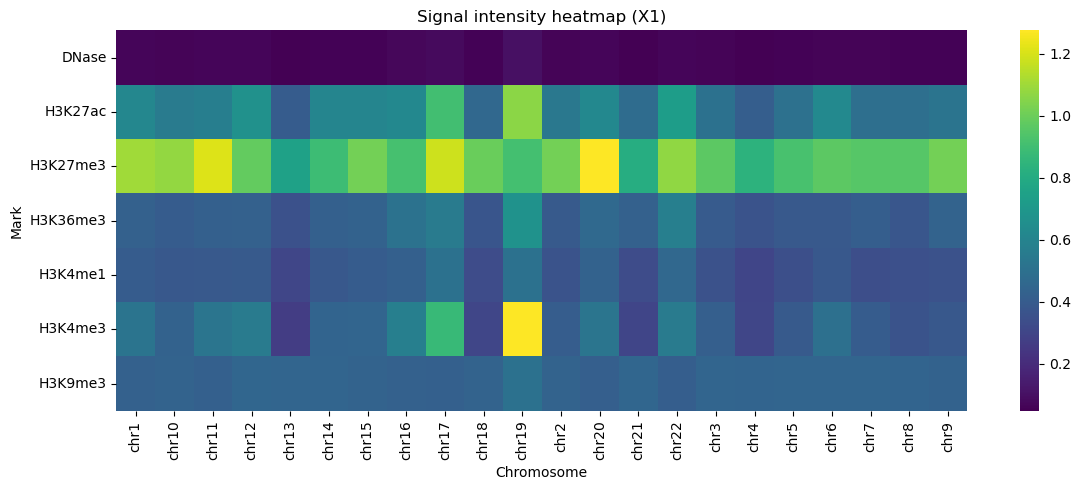

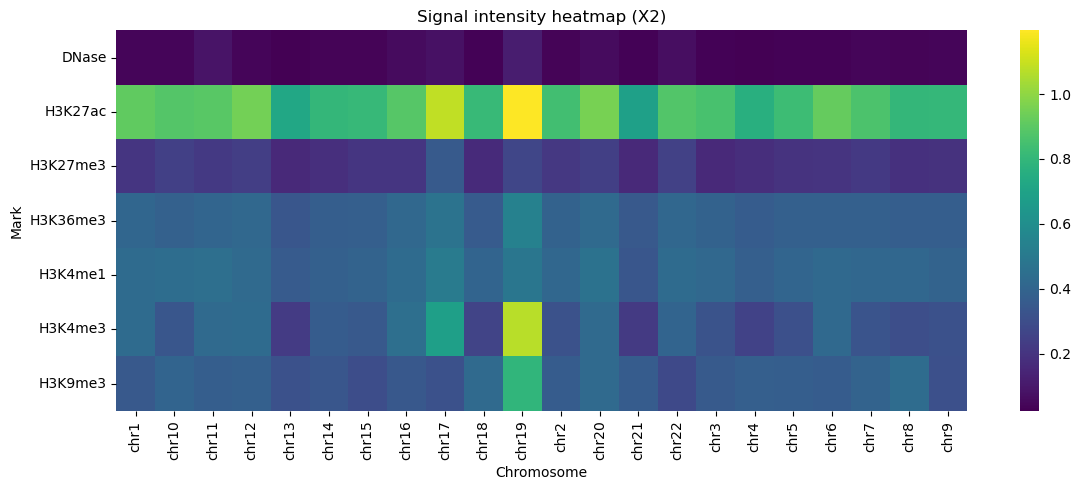

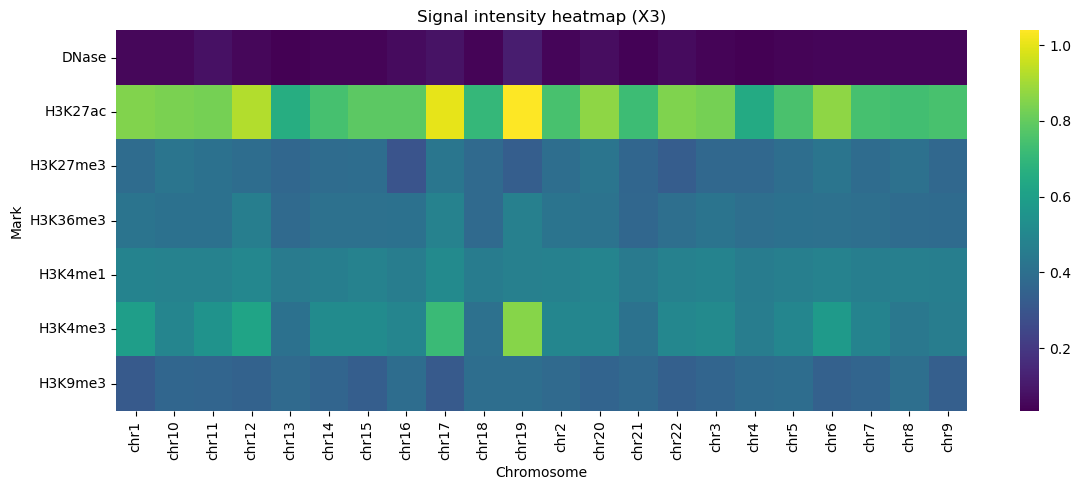

In [1]:
import os
import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt
import seaborn as sns

# === 基本設定 ===
base = "../ML4G_Project_1_Data"
marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
cells = ["X1", "X2", "X3"]
target_chroms = [f"chr{i}" for i in range(1, 23)]

summary_chr = []

# === 計算每個 chromosome 的平均 signal ===
for mark in marks:
    for cell in cells:
        path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bw")
        if not os.path.exists(path_bw):
            path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bigwig")
        if not os.path.exists(path_bw):
            print(f"⚠️ Missing: {mark} ({cell})")
            continue

        print(f"\n📂 Processing {mark} ({cell}) ...")
        bw = pyBigWig.open(path_bw)
        chroms = bw.chroms()

        for chrom in target_chroms:
            if chrom not in chroms:
                continue

            vals = np.array(bw.values(chrom, 0, chroms[chrom], numpy=True))
            vals = vals[~np.isnan(vals)]
            if len(vals) == 0:
                continue

            summary_chr.append({
                "mark": mark,
                "cell": cell,
                "chr": chrom,
                "mean": np.mean(vals),
                "std": np.std(vals)
            })
        bw.close()

# # === 轉成 DataFrame ===
df_chr = pd.DataFrame(summary_chr)
# df_chr.to_csv("bigwig_signal_per_chr.csv", index=False)
# print("💾 Saved → bigwig_signal_per_chr.csv")

# ======================================================
# 📊 可視化 1：每個 cell 各 mark 在各 chr 的平均值
# ======================================================
for cell in cells:
    df_sub = df_chr[df_chr["cell"] == cell]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_sub, x="chr", y="mean", hue="mark", marker="o")
    plt.xticks(rotation=45)
    plt.title(f"Mean signal per chromosome ({cell})")
    plt.ylabel("Mean signal")
    plt.tight_layout()
    plt.show()

# ======================================================
# 📊 可視化 2：Heatmap of marks × chromosomes
# ======================================================
for cell in cells:
    df_sub = df_chr[df_chr["cell"] == cell]
    pivot = df_sub.pivot(index="mark", columns="chr", values="mean")
    plt.figure(figsize=(12, 5))
    sns.heatmap(pivot, cmap="viridis", annot=False)
    plt.title(f"Signal intensity heatmap ({cell})")
    plt.xlabel("Chromosome")
    plt.ylabel("Mark")
    plt.tight_layout()
    plt.show()


💾 Saved → bigwig_signal_per_chr_zscore.csv


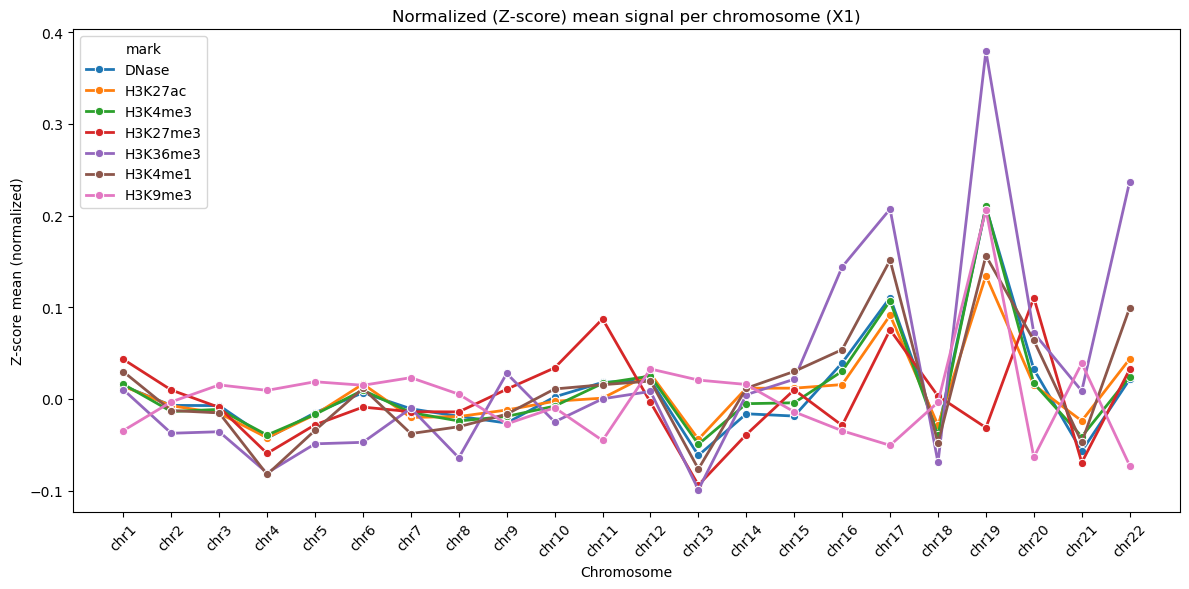

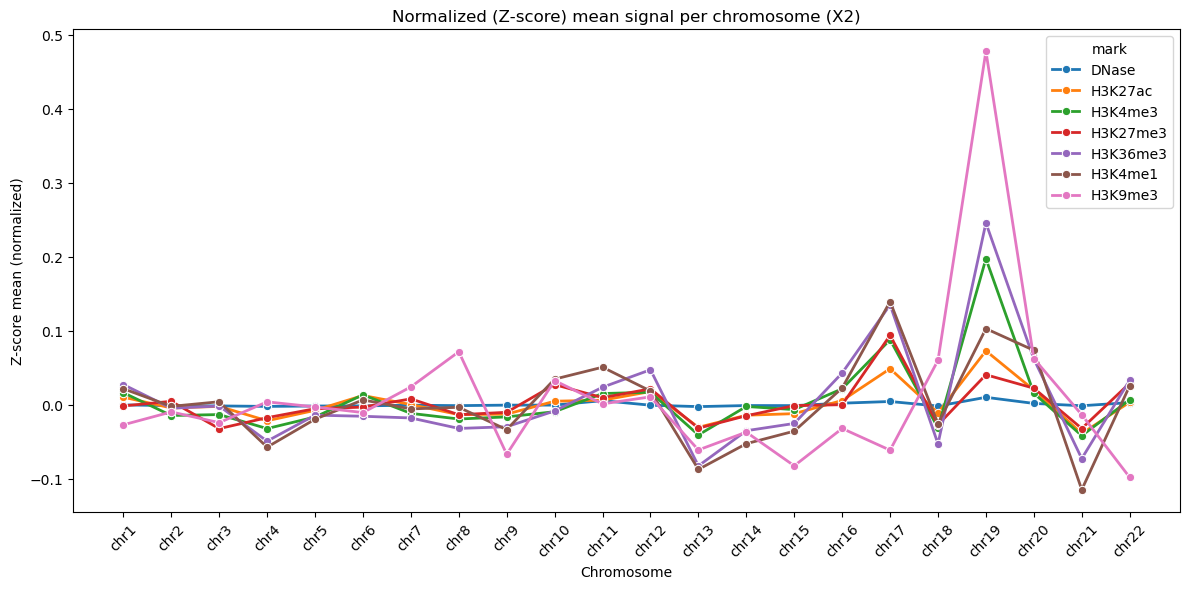

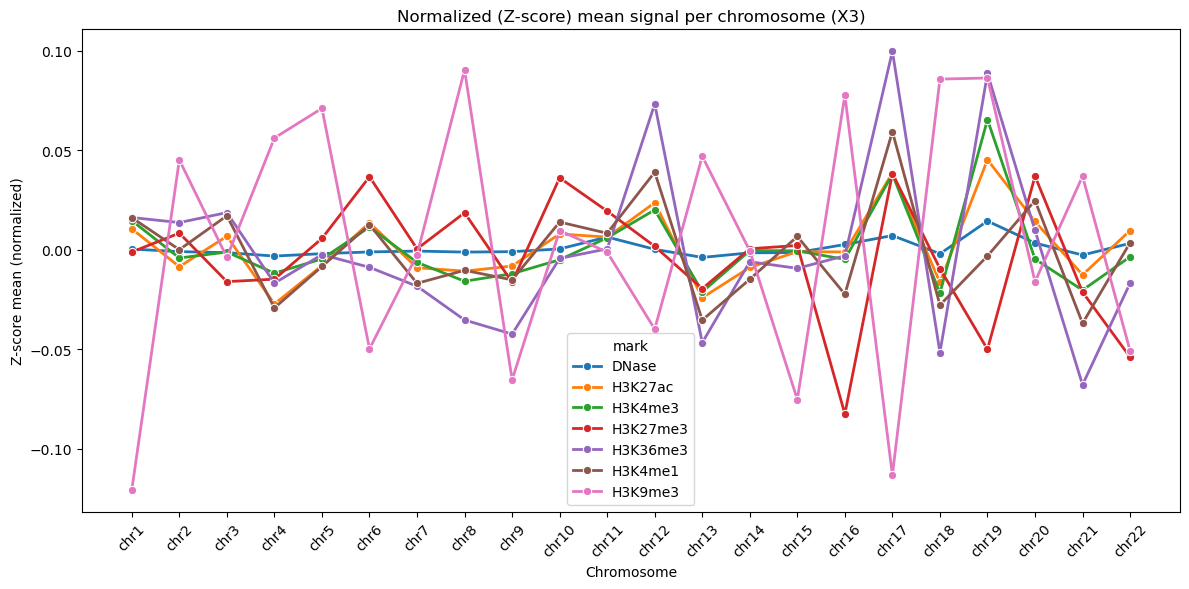

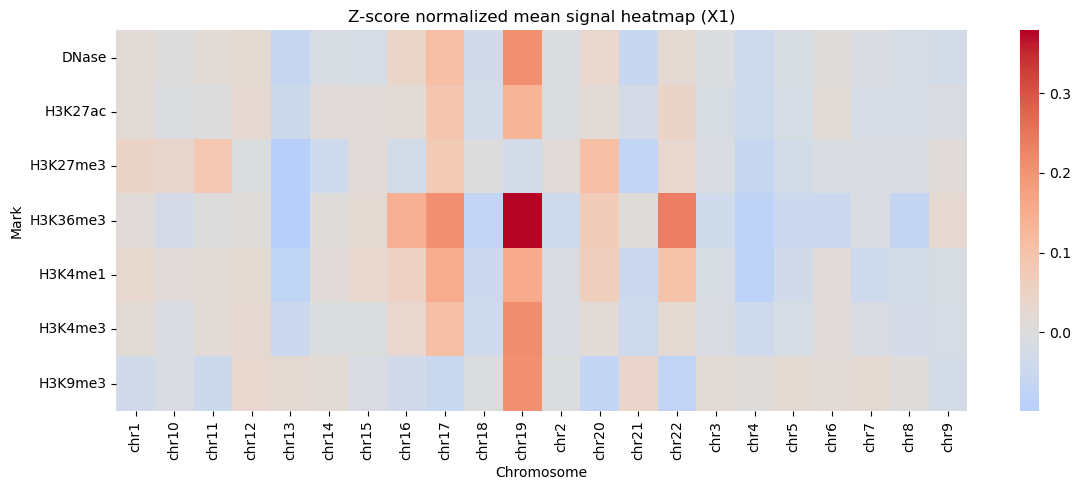

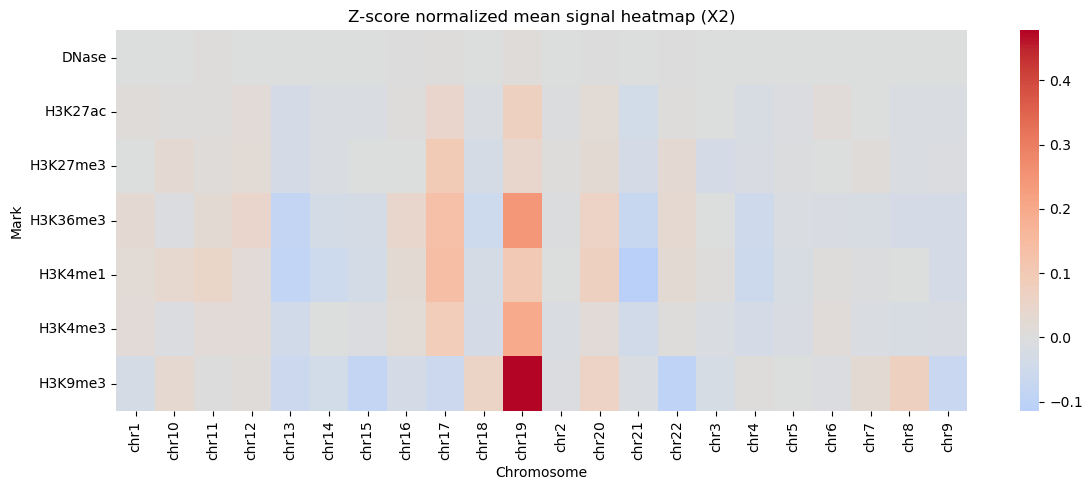

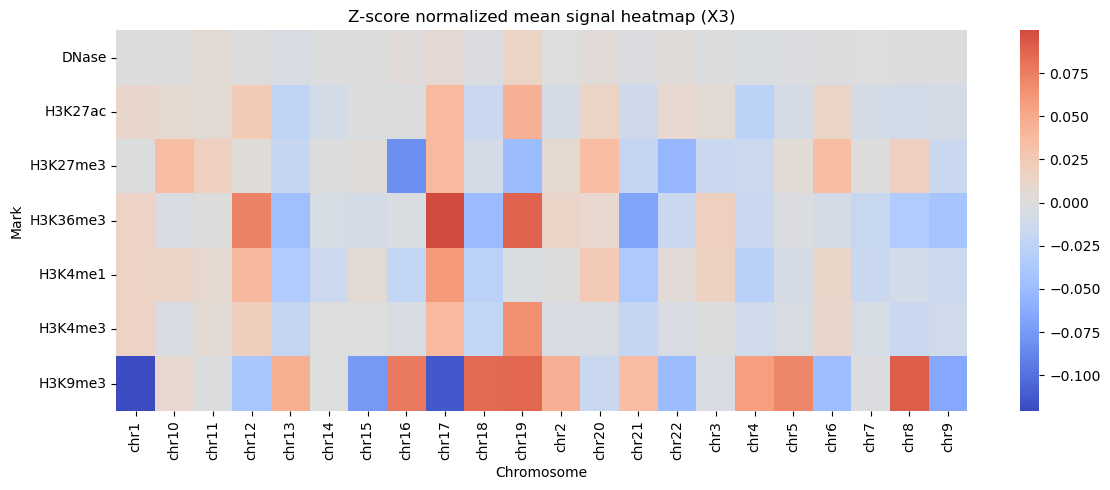

In [3]:
df_chr

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === 載入 per-chromosome 統計結果 ===

# === 載入 global normalization 統計 ===
with open("../preprocessed_data/global_norm_stats.json", "r") as f:
    global_stats = json.load(f)

# === 新增 normalized 值 ===
z_means = []
z_stds = []

for _, row in df_chr.iterrows():
    key = f"{row['mark']}_{row['cell']}"
    if key not in global_stats:
        z_means.append(None)
        z_stds.append(None)
        continue

    gmean = global_stats[key]["mean"]
    gstd = global_stats[key]["std"]

    z_mean = (row["mean"] - gmean) / (gstd + 1e-8)
    z_std = row["std"] / (gstd + 1e-8)

    z_means.append(z_mean)
    z_stds.append(z_std)

df_chr["z_mean"] = z_means
df_chr["z_std"] = z_stds

# === 儲存 normalized 結果 ===
df_chr.to_csv("bigwig_signal_per_chr_zscore.csv", index=False)
print("💾 Saved → bigwig_signal_per_chr_zscore.csv")

# ======================================================
# 📊 視覺化：各 chromosome 的 z-score mean 分佈
# ======================================================
for cell in sorted(df_chr["cell"].unique()):
    df_sub = df_chr[df_chr["cell"] == cell]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=df_sub,
        x="chr",
        y="z_mean",
        hue="mark",
        marker="o",
        linewidth=2
    )
    plt.xticks(rotation=45)
    plt.title(f"Normalized (Z-score) mean signal per chromosome ({cell})")
    plt.ylabel("Z-score mean (normalized)")
    plt.xlabel("Chromosome")
    plt.tight_layout()
    plt.show()

# ======================================================
# 📊 Heatmap: mark × chromosome (Z-mean)
# ======================================================
for cell in sorted(df_chr["cell"].unique()):
    df_sub = df_chr[df_chr["cell"] == cell]
    pivot = df_sub.pivot(index="mark", columns="chr", values="z_mean")
    plt.figure(figsize=(12, 5))
    sns.heatmap(pivot, cmap="coolwarm", center=0)
    plt.title(f"Z-score normalized mean signal heatmap ({cell})")
    plt.xlabel("Chromosome")
    plt.ylabel("Mark")
    plt.tight_layout()
    plt.show()


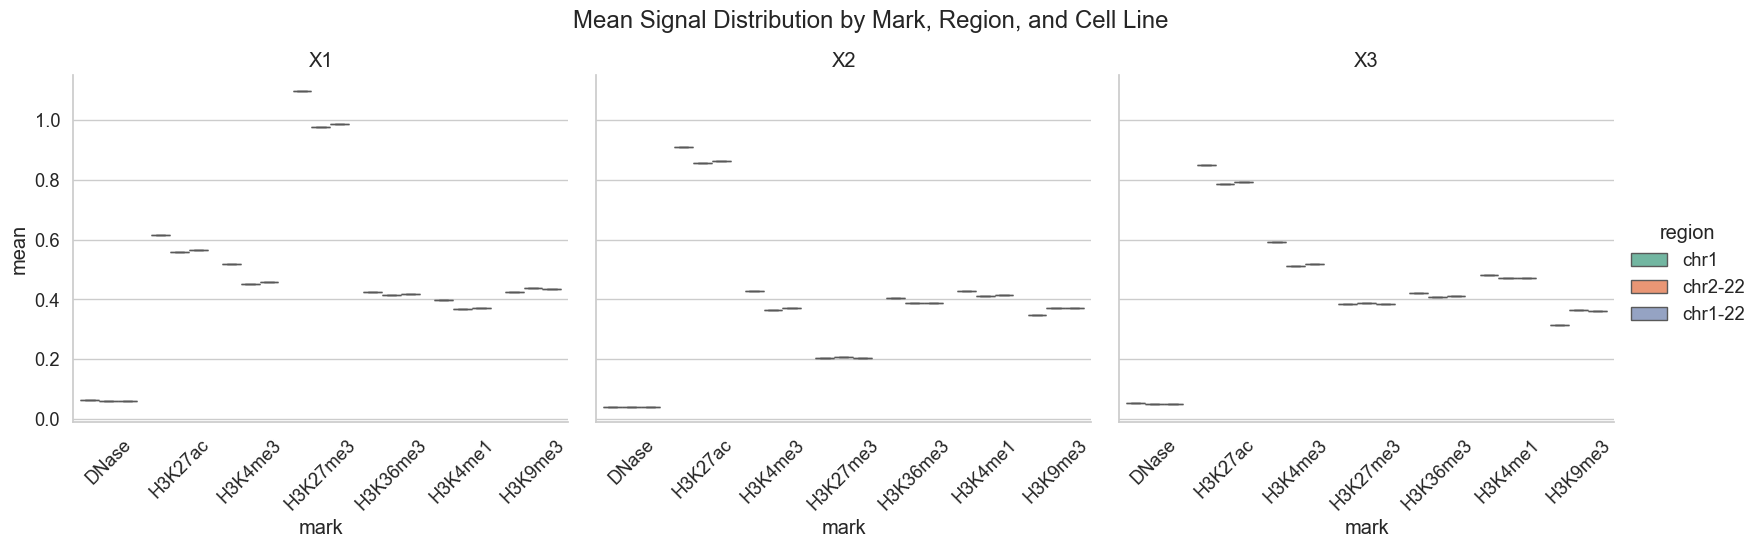

In [14]:
# === 🧠 一行多圖（跨 cell line 對比） ===
sns.set(style="whitegrid", font_scale=1.2)
g = sns.catplot(
    data=summary_df,
    x="mark", y="mean",
    hue="region",  # 顏色區分 chr1 / chr2–22 / all
    col="cell",    # 橫向分 cell line
    kind="box",
    col_order=["X1", "X2", "X3"],
    palette="Set2",
    sharey=True,
    height=5, aspect=1.1
)

g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=45)
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Mean Signal Distribution by Mark, Region, and Cell Line")
plt.show()

# Data Preprocessing

In [1]:
import os
import numpy as np
import pyBigWig
import json

# === 基本設定 ===
base = "../ML4G_Project_1_Data"
out_config = "../preprocessed_data/global_norm_stats.json"
os.makedirs(os.path.dirname(out_config), exist_ok=True)

marks = ["DNase", "H3K27ac", "H3K4me3", "H3K27me3", "H3K36me3", "H3K4me1", "H3K9me3"]
cells = ["X1", "X2", "X3"]
target_chroms = [f"chr{i}" for i in range(1, 23)]

global_stats = {}

for mark in marks:
    for cell in cells:
        path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bw")
        if not os.path.exists(path_bw):
            path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bigwig")
        if not os.path.exists(path_bw):
            print(f"⚠️ Missing: {mark} ({cell})")
            continue

        print(f"\n📂 Processing {mark} ({cell})...")
        bw = pyBigWig.open(path_bw)
        chroms = bw.chroms()

        total_bp = 0
        weighted_sum = 0.0
        weighted_sq_sum = 0.0
        weighted_min_sum = 0.0  # 新增：加權最小值
        min_vals = []           # 追蹤每個染色體的最小值（非加權）

        for chrom in target_chroms:
            if chrom not in chroms:
                continue
            vals = np.array(bw.values(chrom, 0, chroms[chrom], numpy=True))
            vals = vals[~np.isnan(vals)]
            n = len(vals)
            if n == 0:
                continue

            mean_chr = np.mean(vals)
            std_chr = np.std(vals)
            min_chr = np.min(vals)

            # === 累積全域加權統計 ===
            total_bp += n
            weighted_sum += n * mean_chr
            weighted_sq_sum += n * (std_chr**2 + mean_chr**2)
            weighted_min_sum += n * min_chr  # 加權最小值
            min_vals.append(min_chr)

        bw.close()

        if total_bp == 0:
            print(f"⚠️ No data found for {mark}-{cell}, skipping.")
            continue

        # === 計算 global mean/std/min ===
        global_mean = weighted_sum / total_bp
        global_var = weighted_sq_sum / total_bp - global_mean**2
        global_std = np.sqrt(global_var)
        global_min = weighted_min_sum / total_bp if total_bp > 0 else 0.0
        absolute_min = float(np.min(min_vals)) if len(min_vals) > 0 else 0.0  # 全染色體的最小值

        print(f"✅ {mark}-{cell}: mean={global_mean:.4f}, std={global_std:.4f}, min={global_min:.4f} (abs_min={absolute_min:.4f})")

        global_stats[f"{mark}_{cell}"] = {
            "mean": float(global_mean),
            "std": float(global_std),
            "min_weighted": float(global_min),  # 新增：加權最小值
            "min_abs": float(absolute_min),     # 新增：所有chr的最小值
            "n_bases": int(total_bp)
        }

# === 儲存到 JSON 檔案 ===
with open(out_config, "w") as f:
    json.dump(global_stats, f, indent=4)
print(f"\n💾 Saved normalization stats → {out_config}")



📂 Processing DNase (X1)...
✅ DNase-X1: mean=0.0591, std=0.1919, min=0.0241 (abs_min=0.0241)

📂 Processing DNase (X2)...
✅ DNase-X2: mean=0.0406, std=7.5742, min=0.0034 (abs_min=0.0034)

📂 Processing DNase (X3)...
✅ DNase-X3: mean=0.0512, std=4.4270, min=0.0000 (abs_min=0.0000)

📂 Processing H3K27ac (X1)...
✅ H3K27ac-X1: mean=0.5643, std=3.6970, min=0.0000 (abs_min=0.0000)

📂 Processing H3K27ac (X2)...
✅ H3K27ac-X2: mean=0.8620, std=4.5804, min=0.0000 (abs_min=0.0000)

📂 Processing H3K27ac (X3)...
✅ H3K27ac-X3: mean=0.7923, std=5.4479, min=0.2036 (abs_min=0.2036)

📂 Processing H3K4me3 (X1)...
✅ H3K4me3-X1: mean=0.4574, std=3.8905, min=0.0000 (abs_min=0.0000)

📂 Processing H3K4me3 (X2)...
✅ H3K4me3-X2: mean=0.3699, std=3.5539, min=0.0346 (abs_min=0.0346)

📂 Processing H3K4me3 (X3)...
✅ H3K4me3-X3: mean=0.5178, std=5.1500, min=0.0000 (abs_min=0.0000)

📂 Processing H3K27me3 (X1)...
✅ H3K27me3-X1: mean=0.9886, std=2.5569, min=0.0000 (abs_min=0.0000)

📂 Processing H3K27me3 (X2)...
✅ H3K27me

In [2]:
import os
import numpy as np
import pyBigWig
import json

# === 基本設定 ===
base = "../ML4G_Project_1_Data"
out_config = "../preprocessed_data/global_norm_stats.json"
os.makedirs(os.path.dirname(out_config), exist_ok=True)

marks = ["H3K27me3", "H3K4me1", "H3K9me3"]
cells = ["X1", "X2", "X3"]
target_chroms = [f"chr{i}" for i in range(1, 23)]
N_sample_per_chr = int(1e5)  # 每條染色體最多抽樣點數

global_stats = {}

for mark in marks:
    for cell in cells:
        path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bw")
        if not os.path.exists(path_bw):
            path_bw = os.path.join(base, f"{mark}-bigwig", f"{cell}.bigwig")
        if not os.path.exists(path_bw):
            print(f"⚠️ Missing: {mark} ({cell})")
            continue

        print(f"\n📂 Processing {mark} ({cell})...")
        bw = pyBigWig.open(path_bw)
        chroms = bw.chroms()

        total_bp = 0
        weighted_sum = 0.0
        weighted_sq_sum = 0.0
        weighted_min_sum = 0.0
        min_vals = []
        sampled_vals = []  # 用於近似第10百分位

        for chrom in target_chroms:
            if chrom not in chroms:
                continue
            vals = np.array(bw.values(chrom, 0, chroms[chrom], numpy=True))
            vals = vals[~np.isnan(vals)]
            n = len(vals)
            if n == 0:
                continue

            mean_chr = np.mean(vals)
            std_chr = np.std(vals)
            min_chr = np.min(vals)

            # === 累積加權統計 ===
            total_bp += n
            weighted_sum += n * mean_chr
            weighted_sq_sum += n * (std_chr**2 + mean_chr**2)
            weighted_min_sum += n * min_chr
            min_vals.append(min_chr)

            # === 抽樣以估計分位數 ===
            if n > N_sample_per_chr:
                sample_idx = np.random.choice(n, N_sample_per_chr, replace=False)
                sampled_vals.append(vals[sample_idx])
            else:
                sampled_vals.append(vals)

        bw.close()

        if total_bp == 0:
            print(f"⚠️ No data found for {mark}-{cell}, skipping.")
            continue

        # === 計算 global mean/std/min ===
        global_mean = weighted_sum / total_bp
        global_var = weighted_sq_sum / total_bp - global_mean**2
        global_std = np.sqrt(global_var)
        global_min = weighted_min_sum / total_bp if total_bp > 0 else 0.0
        absolute_min = float(np.min(min_vals)) if len(min_vals) > 0 else 0.0

        # === 分位數（抽樣估計） ===
        if sampled_vals:
            all_samples = np.concatenate(sampled_vals)
            p10 = float(np.percentile(all_samples, 10))
        else:
            p10 = 0.0

        print(f"✅ {mark}-{cell}: mean={global_mean:.4f}, std={global_std:.4f}, "
              f"min={global_min:.4f}, p10={p10:.4f}")

        global_stats[f"{mark}_{cell}"] = {
            "mean": float(global_mean),
            "std": float(global_std),
            "min_weighted": float(global_min),
            "min_abs": float(absolute_min),
            "p10": float(p10),                # 新增欄位
            "n_bases": int(total_bp)
        }

# === 儲存 JSON ===
with open(out_config, "w") as f:
    json.dump(global_stats, f, indent=4)

print(f"\n💾 Saved normalization stats → {out_config}")



📂 Processing H3K27me3 (X1)...
✅ H3K27me3-X1: mean=0.9886, std=2.5569, min=0.0000, p10=0.0000

📂 Processing H3K27me3 (X2)...


KeyboardInterrupt: 

In [9]:
import numpy as np

# === 模擬全域資料 ===
np.random.seed(42)
background = np.random.normal(10, 2, 990_000)
local_data = np.random.normal(14, 3, 10_000)
global_data = np.concatenate([background, local_data])

# === 全域統計量 ===
global_mean = np.mean(global_data)
global_std = np.std(global_data)

# === 區域統計量 ===
local_mean = np.mean(local_data)
local_std = np.std(local_data)

# === 把 local_data 用 global mean/std 做 z-score ===
z = (local_data - global_mean) / global_std
z_mean_empirical = np.mean(z)
z_std_empirical = np.std(z)

# === 理論值 ===
z_mean_formula = (local_mean - global_mean) / global_std
z_std_formula = local_std / global_std

# === 輸出結果 ===
print(f"Global mean/std  = {global_mean:.3f}, {global_std:.3f}")
print(f"Local mean/std   = {local_mean:.3f}, {local_std:.3f}")

print("\nAfter global normalization of local_data:")
print(f"  → Empirical z_mean/std  = {z_mean_empirical:.4f}, {z_std_empirical:.4f}")
print(f"  → Theoretical z_mean/std= {z_mean_formula:.4f}, {z_std_formula:.4f}")

# === 驗證誤差 ===
print(f"\nDiff (empirical - theoretical): mean={z_mean_empirical - z_mean_formula:.2e}, std={z_std_empirical - z_std_formula:.2e}")


Global mean/std  = 10.037, 2.051
Local mean/std   = 13.980, 2.966

After global normalization of local_data:
  → Empirical z_mean/std  = 1.9226, 1.4459
  → Theoretical z_mean/std= 1.9226, 1.4459

Diff (empirical - theoretical): mean=0.00e+00, std=-2.22e-16
